In [1]:
# Evaluation.py

# Imports 
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#from training import Generator     #Import Generator Class from Training

# Define the device for the training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model():
    '''
    This function is used to load the saved generator model using PyTorch.
    '''
    model = torch.load(r'./generate.pt')
    model.to(device)
    model.eval()

    return model

def generate_images(model, num_images):
    '''
    Take the model as input and generate a specified number of images.
    '''
    z_dim = 100
    images = []

    for _ in range(num_images):
        
        z = torch.randn(1, z_dim, device=device)
        
        # Scale the tensor to have values in the range [0, 1]
        scaled_z = (z - z.min()) / (z.max() - z.min())

        # Shift the scaled tensor to have values in the range [-1, 1]
        z = scaled_z * 2 - 1
    
        generated_image = model(z).detach().cpu().numpy().reshape(28, 28)
        images.append(generated_image)

    return images


import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

def plot_images(images, grid_size):
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10), tight_layout=True)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.axis("off")

    plt.show()




C:\Users\jun.wen.UNTL\.conda\envs\untl_tf\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\jun.wen.UNTL\.conda\envs\untl_tf\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Create a Generator class.
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        # Define your network architecture.
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = nn.Linear(hidden_size*2, hidden_size*4)
        self.fc4 = nn.Linear(hidden_size*4, output_size)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Define your network data flow. 
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        output = torch.tanh(self.fc4(x))
        return output
    
    
# Create a Generator.
netG = Generator(input_size=100, hidden_size=32, output_size=784)

# Create a Discriminator class.
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # input size is 78 * 78
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 4)
        self.fc2 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.activation = nn.LeakyReLU(0.2)  # LeakyReLU activation for all layers except the output layer
        self.dropout = nn.Dropout(0.2)  # Dropout layer to prevent overfitting

    def forward(self, x):
        # Rehape passed image batch
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # Define your network data flow. 
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        #output = torch.sigmoid(self.fc4(x))  # Sigmoid activation for the output layer to output probabilities
        output = self.fc4(x)
        return output
    

# Create a Discriminator.
netD = Discriminator(input_size=784, hidden_size=32, output_size=1)

# Setup Generator optimizer.
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.9, 0.999))

# Setup Discriminator optimizer.
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.9, 0.999))

# Define loss function. 
#criterion = torch.nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Assuming you've already defined Generator and Discriminator classes

# Define some hyperparameters
batch_size = 64
noise_dim = 100  # Dimensionality of the noise vector
num_epochs = 20
lr = 0.002  # Learning rate # 0.0002 too slow

# Create the generator and discriminator instances
netG = Generator(input_size=noise_dim, hidden_size=32, output_size=784)
netD = Discriminator(input_size=784, hidden_size=32, output_size=1)

# Initialize network weights function
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Initialize the weights of the networks
netD.apply(weights_init_normal)
netG.apply(weights_init_normal)

# Define loss function and optimizer
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

# Prepare the data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
def train():
    d_losses = []
    g_losses = []
    # Move discriminator and generator to available device
    for epoch in range(num_epochs):
        netD.train()
        netG.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for i, (real_images, _) in enumerate(train_loader):
            
            batch_size = real_images.size(0)
            
            # Create labels for real and fake images
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            #######################
            # Train Discriminator #
            #######################

            optimizerD.zero_grad()

            # Train discriminator on real images
            real_images = real_images.view(-1, 28*28)
            real_output = netD(real_images)
            d_loss_real = criterion(real_output, real_labels)
            #d_loss_real.backward()

            # Train discriminator on fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors
                # Generate noise vectors # noise dimension is 100
                # noise = torch.randn(batch_size, noise_dim)
                noise = np.random.uniform(-1, 1, size=(batch_size, noise_dim))
                noise = torch.from_numpy(noise).float().to(device)
                # Generate batch of fake images
                fake_images = netG(noise)
            fake_output = netD(fake_images.detach())  # Detach to avoid backprop through generator
            d_loss_fake = criterion(fake_output, fake_labels)
            #d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizerD.step()
            
            # Save discriminator batch loss
            d_running_batch_loss += (d_loss * batch_size)
            ###########################
            # Train Generator         #
            ###########################

            optimizerG.zero_grad()
        
            # Generate a batch of random latent vectors
            # Generate noise vectors # noise dimension is 100
            # noise = torch.randn(batch_size, noise_dim)
            noise = np.random.uniform(-1, 1, size=(batch_size, noise_dim))
            noise = torch.from_numpy(noise).float().to(device)

            # Generate fake images
            fake_images = netG(noise)

            # Train generator with discriminator's output (validity of generated images)
            output = netD(fake_images)
            g_loss = criterion(output, real_labels)  # Train generator to maximize log(D(G(z)))

            g_loss.backward()
            optimizerG.step()
            
            # Save discriminator batch loss
            g_running_batch_loss += (g_loss * batch_size)

            # Print training info
            if (i+1) % 400 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                      f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
                
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(train_loader)
        g_epoch_loss = g_running_batch_loss.item()/len(train_loader)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Save the trained model
        torch.save(model.state_dict(), 'trained_model.pth')
        
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
    return d_losses, g_losses

print(netG)

print(netD)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [5]:
print(train_dataset.data.shape)
print(train_dataset.targets.shape)
print(train_dataset.classes)
print(train_dataset.data[0])
print(train_dataset.targets[0])
print(train_dataset.data[0].max())
print(train_dataset.data[0].min())
print(train_dataset.data[0].float().mean())
print(train_dataset.data[0].float().std())

torch.Size([60000, 28, 28])
torch.Size([60000])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   

In [6]:
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [13]:
d_losses, g_losses = train()

Epoch [1/20], Step [400/938], Discriminator Loss: 1.0660, Generator Loss: 1.1911
Epoch [1/20], Step [800/938], Discriminator Loss: 1.1278, Generator Loss: 1.2624
epoch_d_loss: 1.233399 	epoch_g_loss: 1.001646
Epoch [2/20], Step [400/938], Discriminator Loss: 1.1557, Generator Loss: 0.9958
Epoch [2/20], Step [800/938], Discriminator Loss: 1.1441, Generator Loss: 0.9863
epoch_d_loss: 1.195686 	epoch_g_loss: 1.030380
Epoch [3/20], Step [400/938], Discriminator Loss: 1.2257, Generator Loss: 1.0087
Epoch [3/20], Step [800/938], Discriminator Loss: 1.2960, Generator Loss: 1.0478
epoch_d_loss: 1.232955 	epoch_g_loss: 0.946021
Epoch [4/20], Step [400/938], Discriminator Loss: 1.2440, Generator Loss: 0.9525
Epoch [4/20], Step [800/938], Discriminator Loss: 1.2500, Generator Loss: 0.9088
epoch_d_loss: 1.260306 	epoch_g_loss: 0.891897
Epoch [5/20], Step [400/938], Discriminator Loss: 1.2662, Generator Loss: 0.7982
Epoch [5/20], Step [800/938], Discriminator Loss: 1.2709, Generator Loss: 0.8310
ep

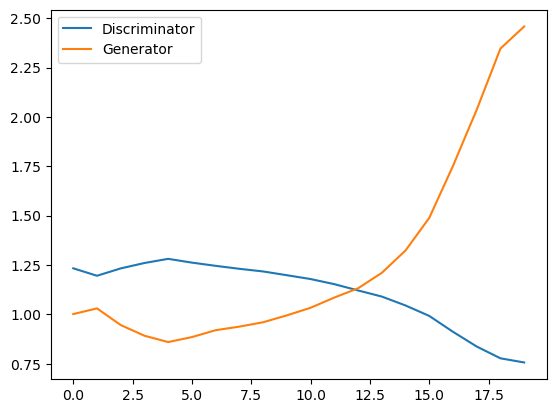

In [14]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [16]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------
import os

import math

os.environ['KMP_DUPLICATE_LIB_OK']='True'

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

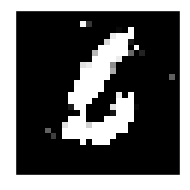

In [30]:
netG.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 100))
z = torch.from_numpy(z).float()
fake_image = netG(z)
# Reshape and display
fake_image = fake_image.view(1, 1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))

In [ ]:
# Generate images
np.random.seed(504)
h = w = 28
num_gen = 25

z = np.random.normal(size=[num_gen, noise_dim])
z = torch.randn(num_gen, noise_dim)
generated_images = generator(z).detach().cpu().numpy()
#model(z).detach().cpu().numpy().reshape(28, 28)

# plot of generation
n = np.sqrt(num_gen).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = generated_images[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(4, 4))
plt.axis("off")
#plt.imshow(I_generated, cmap='gray')
#plt.show()

In [18]:
torch.randn(batch_size, noise_dim)

noise = np.random.uniform(-1, 1, size=(batch_size, noise_dim))
torch.from_numpy(noise).float().to(device)

tensor([[-0.4818,  0.0916, -0.8423,  ..., -0.6017,  0.7489,  0.9487],
        [-0.4865, -0.5762,  0.2096,  ...,  0.3826, -0.2703,  0.4231],
        [-0.5138,  0.8593,  0.8769,  ..., -0.4241, -0.6646,  0.6746],
        ...,
        [ 0.7211, -0.7008, -0.9794,  ...,  0.2265, -0.8838, -0.9475],
        [ 0.1065,  0.4379,  0.6281,  ...,  0.1368, -0.7294,  0.1506],
        [-0.8009, -0.5624, -0.2041,  ...,  0.1491, -0.4829,  0.7475]])